## Importações

In [572]:
%matplotlib inline

import sys
import lumapi
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.constants import c
import utils

In [573]:
inter = lumapi.INTERCONNECT()

In [574]:
um = 1e-6
nm = 1e-9

x1 = 1546.2925*nm
x2 = x1 + 1.59*nm

Com o uso de Y-Branch na entrada e saída do MZI, não é possível obter, em uma única simulação, transmissões defasadas (assim como observado em MZI com saída utilizando acoplador direcional). Para isso, é somada uma parcela $x$ ao $\Delta L$, onde:

$$x = \frac{\lambda}{2n_{eff}}$$

In [575]:
lamb = 1560.4*nm
neff = 2.353696366632936
ngroup = 4.242296678553947

FSR = np.array([2*(x2-x1)])

delta_L = (lamb**2)/(ngroup*FSR)

x_transmissao_defasada = lamb/(2*neff)
print(x_transmissao_defasada*1e6)
print(delta_L*1e6)

0.3314786100112437
[180.48608573]


## Criação e posicionamento dos blocos

In [576]:

inter.switchtodesign()
inter.deleteall()

inter.addelement('Optical Network Analyzer')
inter.set("number of points",1000)
inter.set("number of input ports",2)
inter.set("input parameter",2)
inter.set("start frequency", c/(1500*nm))
inter.set("stop frequency", c/(1600*nm))

guia_menor = 50*um

# 1 - ideal
# 2 - simulado
# 3 - pdk
caso = 3
#delta_L[0] 5.5um

indice = 0
delta_L = delta_L[indice]


inter.expressioncheckoff()
inter.addelement("ebeam_bdc_te1550")
inter.set("name", "Y1")

inter.select("Y1")
inter.copy()
inter.set("name","Y2")
inter.rotateelement("Y2")
inter.rotateelement("Y2")

inter.addelement('ebeam_wg_integral_1550')
inter.set("name", "Guia_1")
inter.set("annotate", False)
inter.set("wg_length", guia_menor + delta_L )
inter.set("wg_width", 500e-9)

inter.addelement('ebeam_wg_integral_1550')
inter.set("name", "Guia_2")
inter.set("annotate", False)
inter.set("wg_length", guia_menor)
inter.set("wg_width", 500e-9)

inter.setposition("ONA_1",0,0)
inter.setposition("Y1",-200,250)
inter.setposition("Y2",200,250)
inter.setposition("Guia_1",0,175)
inter.setposition("Guia_2",0,325)


## Conexão dos blocos

In [577]:

inter.connect("Y1", "opt_3", "Guia_1", "port 1")
inter.connect("Y1", "opt_4", "Guia_2", "port 1")
inter.connect("Guia_1", "port 2", "Y2", "opt_4")
inter.connect("Guia_2", "port 2", "Y2", "opt_3")
inter.connect("ONA_1", "output", "Y1", "opt_1")
inter.connect("ONA_1", "input 1", "Y2", "opt_1")    
inter.connect("ONA_1", "input 2", "Y2", "opt_2")    


1.0

In [578]:
inter.run()

## Obtenção de resultados

In [579]:
if (caso == 1):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['TE gain (dB)'])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["TE free spectral range (m)"]

elif (caso == 2):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['mode 1 gain (dB)'])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["mode 1 free spectral range (m)"]
    
elif (caso == 3):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")["TE gain (dB)"])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["TE free spectral range (m)"]
    
    TE_gain2 = np.squeeze(inter.getresult("ONA_1","input 2/mode 1/gain")["TE gain (dB)"])
    FSR2 = inter.getresult("ONA_1","input 2/mode 1/peak/free spectral range")
    fsr_wv2= np.squeeze(FSR2['wavelength'])
    FSR2 = FSR2["TE free spectral range (m)"]
    

comprimentos_de_onda = np.squeeze(inter.getresult("ONA_1","input 2/mode 1/gain")['wavelength'])

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\4247761219.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L*1e6:.3f} $\mu$")
C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\4247761219.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L*1e6:.3f} $\mu$")
C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\4247761219.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt

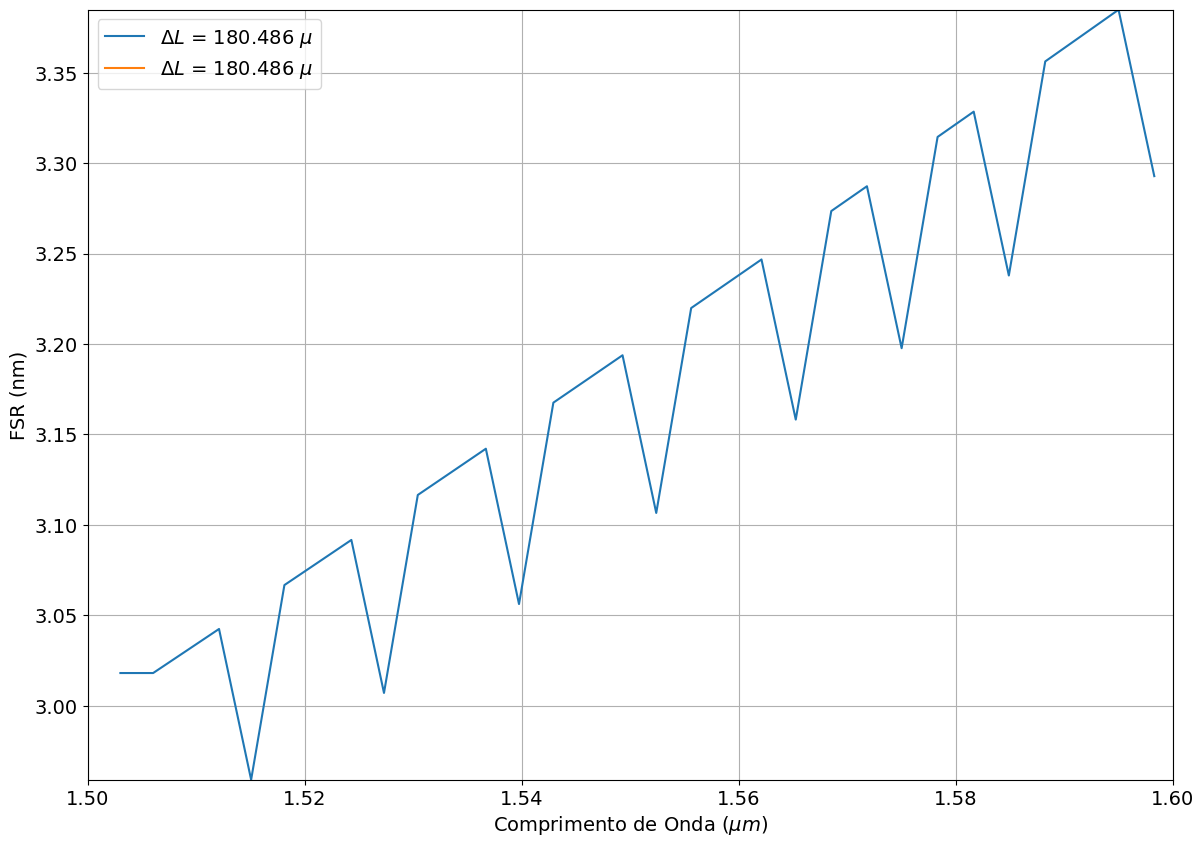

In [580]:
plt.figure(figsize=(14,10))

plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L*1e6:.3f} $\mu$")
plt.plot(fsr_wv2*1e6,FSR2*1e9, label = f"$\Delta L$ = {delta_L*1e6:.3f} $\mu$")
plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)
plt.ylabel('FSR (nm)', fontsize = 14)

plt.tick_params(axis='both', labelsize=14)

plt.xlim(1.5,1.6)
plt.ylim(min(FSR1*1e9) ,max(FSR1*1e9))

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)

plt.savefig(f'FSR {FSR[indice]*1e9:.2f} PDK.png')
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\D'
C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\3270094834.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)
C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\3270094834.py:7: SyntaxWarning: invalid escape sequence '\D'
  plt.title(f"$\Delta_L = {delta_L*1e6:.2f} um$")


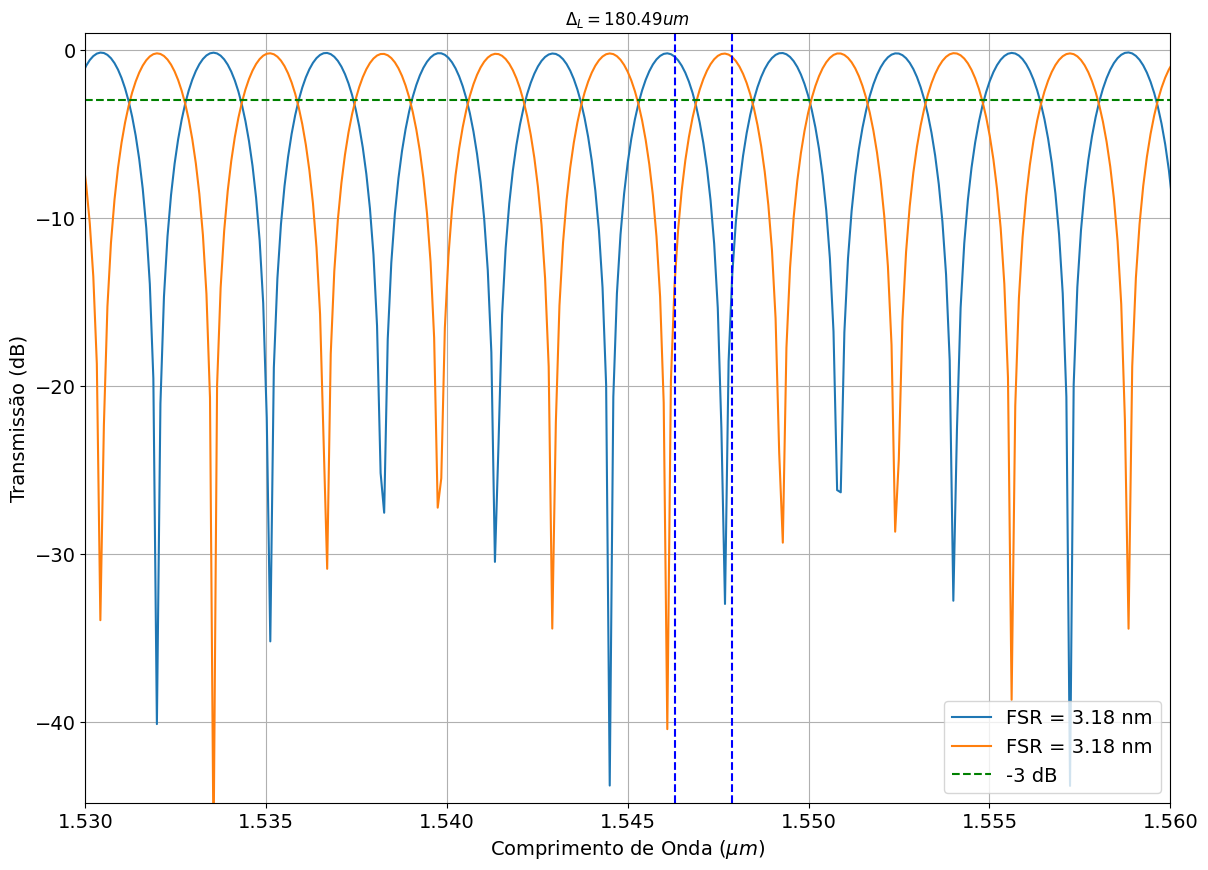

In [581]:

plt.figure(figsize=(14,10))

plt.plot(comprimentos_de_onda*1e6,TE_gain, label = f"FSR = {FSR[indice]*1e9:.2f} nm")
plt.plot(comprimentos_de_onda*1e6,TE_gain2, label = f'FSR = {FSR[indice]*1e9:.2f} nm')
plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)
plt.ylabel('Transmissão (dB)', fontsize = 14)
plt.title(f"$\Delta_L = {delta_L*1e6:.2f} um$")
plt.axhline(y=-3, linestyle='--', color ="g",label = '-3 dB')
plt.axvline(x=x1*1e6, linestyle='--', color ="b")
plt.axvline(x=x2*1e6, linestyle='--', color ="b")
plt.tick_params(axis='both', labelsize=14)

plt.xlim(1.53,1.560)
plt.ylim(min(TE_gain) - 1 ,1)

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)

plt.savefig(f'GANHO IDEAL FSR {FSR[indice]*1e9:.2f}nm E DEFASADO.png')
plt.show()


In [582]:

x1_defasado = x2-x1
S = np.linspace(0,0.004,15)


In [583]:
pmS1 = np.zeros([15])
pmS2 = np.zeros([15])

for i in range(15):
    P1,P2 = utils.funcao_que_gera_o_ambiente_de_simulacao_e_calcula_a_potencia_na_saida_de_n_laser_mzi(inter,guia_menor,delta_L,x1,x1_defasado,fr"C:\Users\gson5\Downloads\Photonics-API-lumapi\MZI FOR SILICON BRAGG\BRAGG STRAIN DOIS PHASE SHIFTER\bragg_strain_{i+1}.dat")
    pmS2[i] = P2
    pmS1[i] = P1

C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\4045246099.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(


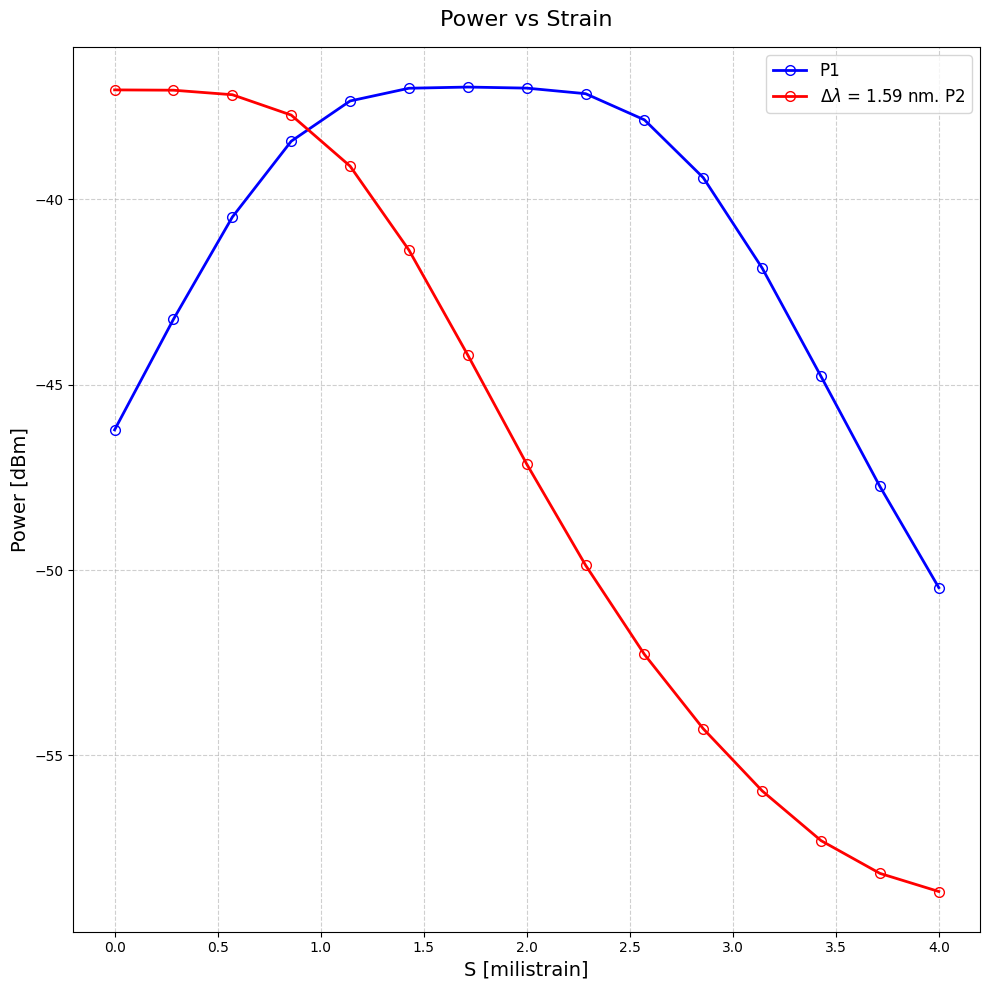

In [584]:
plt.figure(figsize=(10, 10))

plt.plot(
    S*1e3, pmS1,
    '-o',
    markerfacecolor='none',
    markersize=7,
    linewidth=2,
    linestyle = "-",
    color = "blue",
    label="P1"
)

plt.plot(
    S*1e3, pmS2,
    '-o',
    markerfacecolor='none',
    markersize=7,
    linewidth=2,
    color = "red",
    label=fr"$\Delta \lambda$ = {x1_defasado*1e9:.2f} nm. P2"

)

plt.xlabel("S [milistrain]", fontsize=14)
plt.ylabel("Power [dBm]", fontsize=14)
plt.title("Power vs Strain", fontsize=16, pad=15)

plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()


<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\3299513985.py:11: SyntaxWarning: invalid escape sequence '\D'
  label=f"$\Delta \lambda$  = {x1_defasado*1e9:.2f} nm"


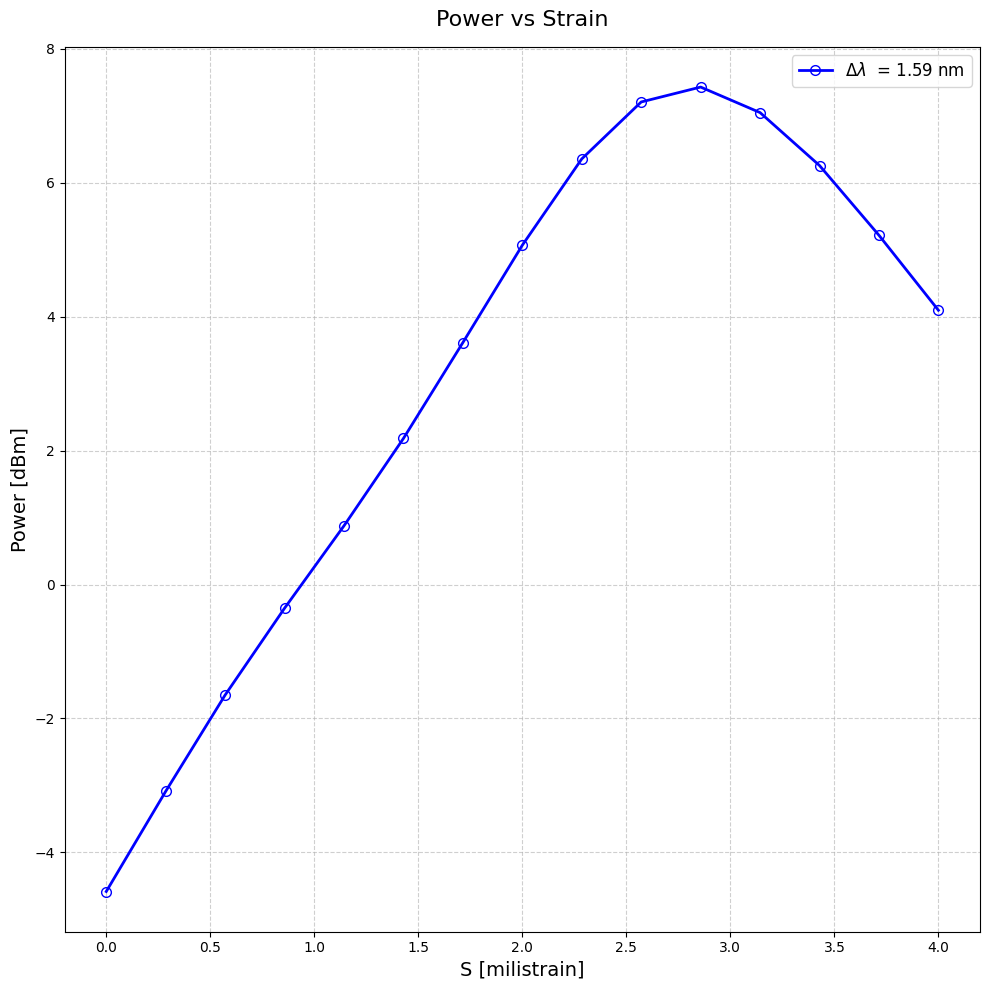

In [585]:

plt.figure(figsize=(10, 10))

# Linha 1 com bolas vazadas
plt.plot(
    S*1e3, (pmS1-pmS2)/2,
    '-o',
    color='blue',
    markerfacecolor='none',
    markersize=7,
    linewidth=2,
    label=f"$\Delta \lambda$  = {x1_defasado*1e9:.2f} nm"
)

# Labels e título
plt.xlabel("S [milistrain]", fontsize=14)
plt.ylabel("Power [dBm]", fontsize=14)
plt.title("Power vs Strain", fontsize=16, pad=15)

# Estética
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Salvar em alta resolução

plt.show()


In [586]:
indice_do_vetor_ate_onde_a_razao_eh_linear = 10
indice_do_grafico = 0


razao=(np.array(pmS1)-np.array(pmS2))/2
razao_ajustada = razao[0:indice_do_vetor_ate_onde_a_razao_eh_linear]
print(razao[indice_do_vetor_ate_onde_a_razao_eh_linear-1])
S_ajustado = S[0:indice_do_vetor_ate_onde_a_razao_eh_linear]

a, b = np.polyfit(S_ajustado, razao_ajustada, 1)
y_fit = a*S_ajustado + b

sensibilidade = (razao[indice_do_vetor_ate_onde_a_razao_eh_linear-1]-razao[0])/((S[indice_do_vetor_ate_onde_a_razao_eh_linear-1]-S[0]))
sensibilidade_fit = (y_fit[indice_do_vetor_ate_onde_a_razao_eh_linear-1]-y_fit[0])/((S_ajustado[indice_do_vetor_ate_onde_a_razao_eh_linear-1]-S_ajustado[0]))
erro_percentual = np.abs((razao_ajustada - y_fit) / razao_ajustada) * 100
erro_medio = np.mean(erro_percentual)
desvio_padrao_do_erro_percentual = np.std(erro_percentual)

print(y_fit[indice_do_vetor_ate_onde_a_razao_eh_linear-1])
print(y_fit[0])

print(razao[indice_do_vetor_ate_onde_a_razao_eh_linear-1])
print(razao[0])

print(S[indice_do_vetor_ate_onde_a_razao_eh_linear-1]*1e3)
print(S_ajustado[indice_do_vetor_ate_onde_a_razao_eh_linear-1]*1e3)

print("")
print(sensibilidade, "por milistrain - simulado")
print(sensibilidade_fit, "por milistrain - fit")
print(f"Erro percentual medio= {erro_medio:.3f} %")
print("Desvio padrao do erro percentual =", desvio_padrao_do_erro_percentual)


7.20835014081441
7.5379800155509304
-4.410503162263145
7.20835014081441
-4.5843391770937885
2.5714285714285716
2.5714285714285716

4586.0458458531875 por milistrain - simulado
4646.632346927696 por milistrain - fit
Erro percentual medio= 4.842 %
Desvio padrao do erro percentual = 5.741586978915935


C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\3055652628.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=12)
C:\Users\gson5\AppData\Local\Temp\ipykernel_41452\3055652628.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

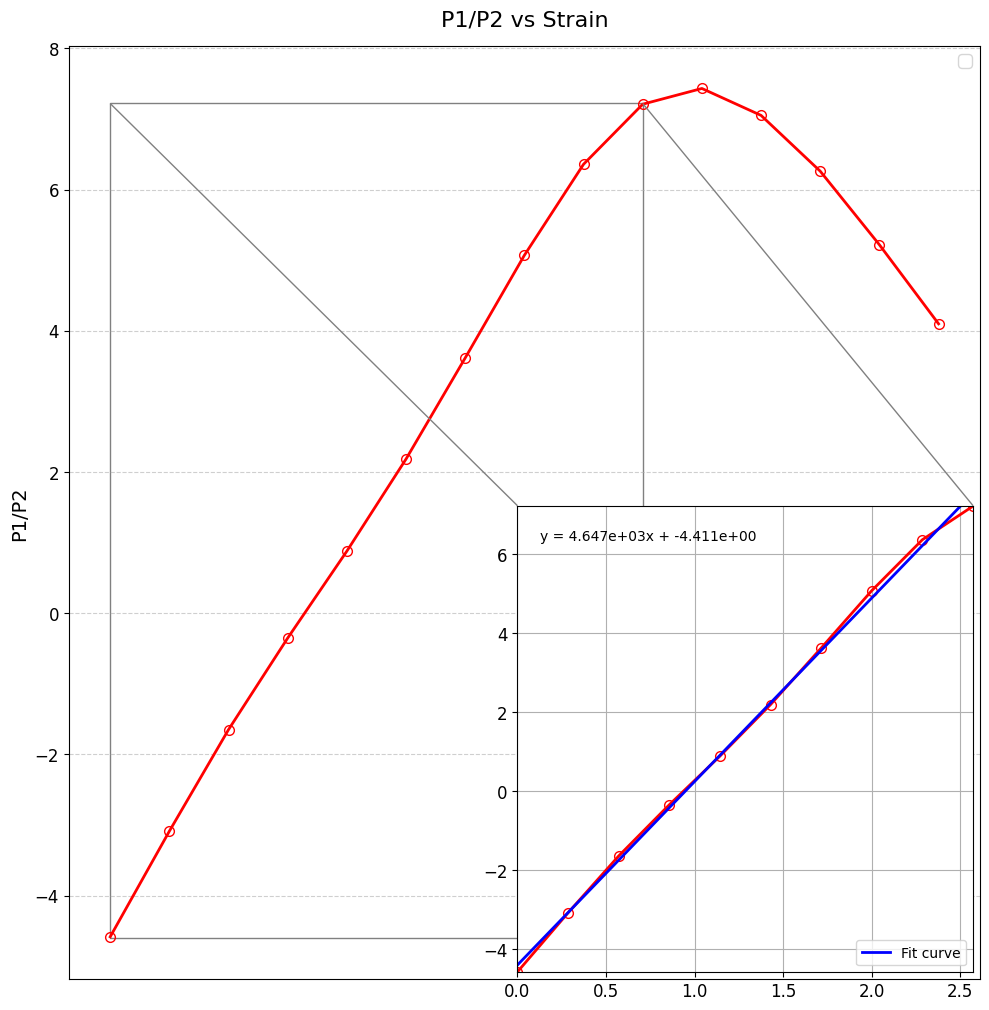

7.206077705056094


In [587]:
plt.figure(figsize=(10, 10))

fig, ax = plt.subplots(figsize=(10, 10))
interacoes = 1
ax.plot(
    S*1e3,(np.array(pmS1)-np.array(pmS2))/2,
    '-o',
    color="red",
    markerfacecolor='none',
    markersize=7,
    linewidth=2        )

ax.set_xlabel("Strain [milistrain]", fontsize=14)
ax.set_ylabel("P1/P2", fontsize=14)
ax.set_title("P1/P2 vs Strain", fontsize=16, pad=15)
ax.legend(fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.set_visible(False)  # remove o eixo x e os ticks
ax.tick_params(axis='both', which='major', labelsize=12)  # muda tamanho dos números do eixo x e y

# Criando o inset (zoom)
axins = inset_axes(ax, width="50%", height="50%", loc='lower right')

y = (np.array(pmS1)-np.array(pmS2))/2
axins.plot(
    S*1e3, y,
    '-o',
    color="red",
    markerfacecolor='none',
    markersize=7,
    linewidth=2
        )

axins.plot(
            S_ajustado*1e3, y_fit,
            '-',
            color='blue',
            alpha=1,
            linewidth=2,
            label = "Fit curve"
        )

# Limites do zoom — ajuste conforme região que deseja destacar
x1, x2 = S[0]*1e3, S[indice_do_vetor_ate_onde_a_razao_eh_linear-1]*1e3  # exemplo de limites no eixo x
y1, y2 = min(razao_ajustada)-0.01, max(razao_ajustada)+0.01  # exemplo de limites no eixo y
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.legend()
axins.grid()
# Texto da equação (formatado)
equacao = f"y = {a:.3e}x + {b:.3e}"
plt.text(0.05, 0.95, equacao, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')

# Linha que conecta inset ao gráfico principal
mark_inset(ax, axins, loc1=(1), loc2=2, fc="none", ec="0.5")
axins.tick_params(axis='both', which='major', labelsize=12)  # muda tamanho dos números do eixo x e y

plt.tight_layout()
plt.show()

S_novo = 2.5*1e-3  # exemplo
y_fit_novo = a * (S_novo) + b
print(y_fit_novo)